# Import Modules 

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer,Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,RandomRotation,RandomFlip,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1,L2
import matplotlib.pyplot as plt

# Define Variables

In [5]:
train_dic = '/kaggle/input/handwritten-math-symbols/dataset'
BATCH_SIZE = 32
IMG_SIZE = 224
LR = 0.01
CLASS_NAME = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
              'add', 'dec', 'div', 'eq', 'mul', 'sub', 'x', 'y', 'z']
N_CLASS = len(CLASS_NAME)

# Create a Dataset

In [32]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dic,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=None,
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=99,
)

Found 10071 files belonging to 19 classes.


In [33]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Data Augmantation

In [34]:
augmantation_layer = Sequential([
    RandomRotation(factor = (0.25,0.2501),),
    RandomFlip(mode = 'horizontal',),
])

In [35]:
def augmantation(image,label):
    return augmantation_layer(image,training = True),label

In [36]:
train_data_1 = train_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration = True)
train_data_2 = train_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration = True)

mix_data = tf.data.Dataset.zip((train_data_1,train_data_2))

In [37]:
def mixup(train_dataset_1,train_dataset_2):

  (img_1,label_1),(img_2,label_2) = train_dataset_1,train_dataset_2


  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*img_1 + (1-lamda)*img_2
  label = lamda*tf.cast(label_1,dtype = tf.float32) + (1-lamda)*tf.cast(label_2,dtype = tf.float32)
  return image,label

In [38]:
train_dataset =mix_data.shuffle(buffer_size=8,reshuffle_each_iteration = True).map(mixup).batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None))>

# Model (***VGG16***)

In [2]:
class ConvBlock2D(Layer):
    def __init__(self, num_filters, num_block, dropout_rate=0.1):
        super(ConvBlock2D, self).__init__(name=f'ConvBlock_{num_block}')
        
        self.conv = Conv2D(filters=num_filters, kernel_size=3, activation='relu', kernel_regularizer=L2(l2=0.01))
        self.batch_norm = BatchNormalization()
        self.dropout = Dropout(dropout_rate) if dropout_rate > 0 else None

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.batch_norm(x, training=training)
        if self.dropout:
            x = self.dropout(x, training=training)
        return x

In [3]:
class VGG16(Model):
    def __init__(self):
        super(VGG16, self).__init__(name='VGG16')
        
        self.conv_1_1 = ConvBlock2D(64, '1_1')
        self.conv_1_2 = ConvBlock2D(64, '1_2')
        self.maxpool_1 = MaxPool2D()
        
        self.conv_2_1 = ConvBlock2D(128, '2_1')
        self.conv_2_2 = ConvBlock2D(128, '2_2')
        self.maxpool_2 = MaxPool2D()
        
        self.conv_3_1 = ConvBlock2D(256, '3_1')
        self.conv_3_2 = ConvBlock2D(256, '3_2')
        self.maxpool_3 = MaxPool2D()
        
        self.conv_4_1 = ConvBlock2D(512, '4_1')
        self.conv_4_2 = ConvBlock2D(512, '4_2')
        self.conv_4_3 = ConvBlock2D(512, '4_3')
        self.maxpool_4 = MaxPool2D()
        
        self.conv_5_1 = ConvBlock2D(512, '5_1')
        self.conv_5_2 = ConvBlock2D(512, '5_2')
        self.conv_5_3 = ConvBlock2D(512, '5_3')
        self.maxpool_5 = MaxPool2D()
        
        self.flatten = Flatten()
        self.dense_1 = Dense(4096, activation='relu')
        self.batch_1 = BatchNormalization()
        self.dropout_1 = Dropout(0.5)
        
        self.dense_2 = Dense(4096, activation='relu')
        self.batch_2 = BatchNormalization()
        self.dropout_2 = Dropout(0.5)
        
        self.dense_3 = Dense(1000, activation='relu')
        self.batch_3 = BatchNormalization()
        self.dropout_3 = Dropout(0.5)
        
        self.dense_4 = Dense(N_CLASS, activation='softmax')
        
    def call(self, inputs, training=False):
        x = self.conv_1_1(inputs, training=training)
        x = self.conv_1_2(x, training=training)
        x = self.maxpool_1(x)
        
        x = self.conv_2_1(x, training=training)        
        x = self.conv_2_2(x, training=training)
        x = self.maxpool_2(x)
        
        x = self.conv_3_1(x, training=training)        
        x = self.conv_3_2(x, training=training)        
        x = self.maxpool_3(x)
        
        x = self.conv_4_1(x, training=training)        
        x = self.conv_4_2(x, training=training)        
        x = self.conv_4_3(x, training=training)        
        x = self.maxpool_4(x)
        
        x = self.conv_5_1(x, training=training)        
        x = self.conv_5_2(x, training=training)        
        x = self.conv_5_3(x, training=training)  
        x = self.maxpool_5(x)
        
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x, training=training)
        x = self.dropout_1(x, training=training)
        
        x = self.dense_2(x)
        x = self.batch_2(x, training=training)
        x = self.dropout_2(x, training=training)
        
        x = self.dense_3(x)
        x = self.batch_3(x, training=training)
        x = self.dropout_3(x, training=training)
        
        x = self.dense_4(x)
        
        return x

In [6]:
vgg16 = VGG16()
vgg16(tf.zeros([1,224,224,3]))
vgg16.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvBlock_1_1 (ConvBlock2D  multiple                  2048      
 )                                                               
                                                                 
 ConvBlock_1_2 (ConvBlock2D  multiple                  37184     
 )                                                               
                                                                 
 max_pooling2d_5 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 ConvBlock_2_1 (ConvBlock2D  multiple                  74368     
 )                                                               
                                                                 
 ConvBlock_2_2 (ConvBlock2D  multiple                  148096

# loss

In [69]:
loss_function = CategoricalCrossentropy()

# Compile the Model

In [71]:
vgg16.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = loss_function,
    metrics=['accuracy']
)

# Train Model

In [80]:
history = vgg16.fit(
    train_dataset,
    epochs = 20,
    verbose = 1
)

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 114s 356ms/step - accuracy: 0.8901 - loss: 1.1735
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 116s 363ms/step - accuracy: 0.8890 - loss: 1.1915
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 117s 364ms/step - accuracy: 0.8881 - loss: 1.1758
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 117s 365ms/step - accuracy: 0.8976 - loss: 1.1571
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 117s 365ms/step - accuracy: 0.9003 - loss: 1.1480
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 116s 365ms/step - accuracy: 0.8832 - loss: 1.1971
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 117s 365ms/step - accuracy: 0.9051 - loss: 1.1251
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 116s 365ms/step - accuracy: 0.8944 - loss: 1.1535
Epoch 9/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 116s 365ms/step - accuracy: 0.8918 - loss: 1.1592
Epoch 10/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 116s 365ms/step - accuracy: 0.9010 - loss: 1.1228
Epoch 11/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 116s 365ms/step - accuracy: 0.9066 - loss: 1.1008
Epoch 12

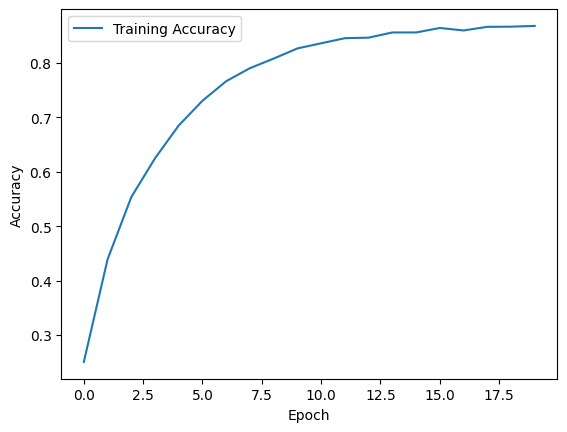

In [75]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

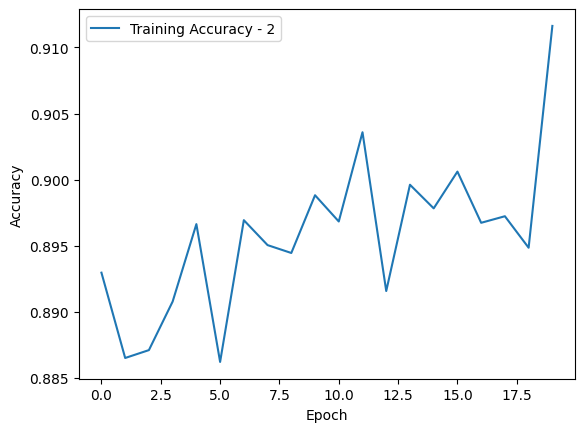

In [81]:
plt.plot(history.history['accuracy'], label='Training Accuracy - 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

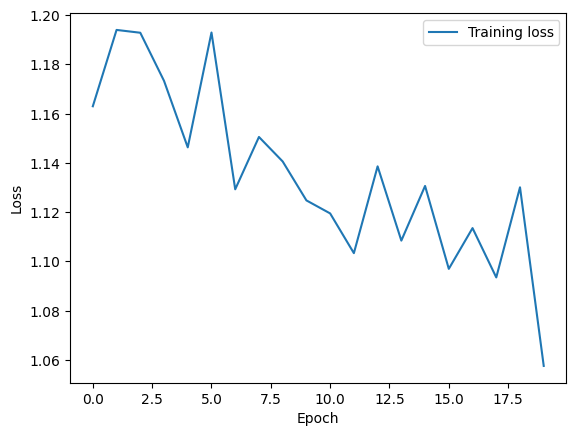

In [82]:
plt.plot(history.history['loss'], label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

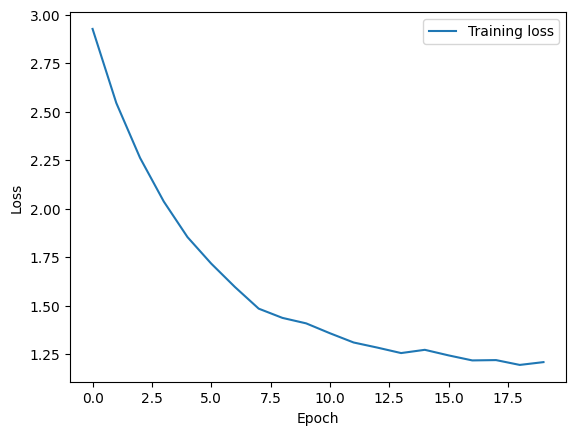

In [79]:
plt.plot(history.history['loss'], label='Training loss - 2 ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [85]:
vgg16.save('vgg16_1.h5')